**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re,unicodedata
from bs4 import BeautifulSoup
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer

!pip install contractions
import contractions

!pip install emoji
import emoji

!pip install demoji
import demoji
demoji.download_codes()

import functools
import operator

from sklearn.feature_extraction.text import CountVectorizer          
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
     |████████████████████████████████| 327kB 6.2MB/s 
     |████████████████████████████████| 266kB 28.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85388 sha256=197292b20097ad80a1985144811abaf10cc87870a9efc470b55e989f7fcc5542
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 133kB 4.1MB/s 
... OK (Got response in 0.53 secon

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load dataset**

In [3]:
tweets_data = pd.read_csv('/content/drive/MyDrive/ML_colab/Tweets.csv')

**Print the shape**

In [4]:
tweets_data.shape

(14640, 15)

There are 14640 rows and 15 columns.

In [5]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

There are some null values in negativereason, negativereason_confidence, airline_sentiment_gold, negativereason_gold, tweet_coord, tweet_location, user_timezone.

In [6]:
tweets_data.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [7]:
tweets_data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
tweets_data['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

This dataset contains tweets for 6 American airlines.Most of the tweets are for Unites airlines followed by US Airways,American,Southwest,Delta,Virgin America.

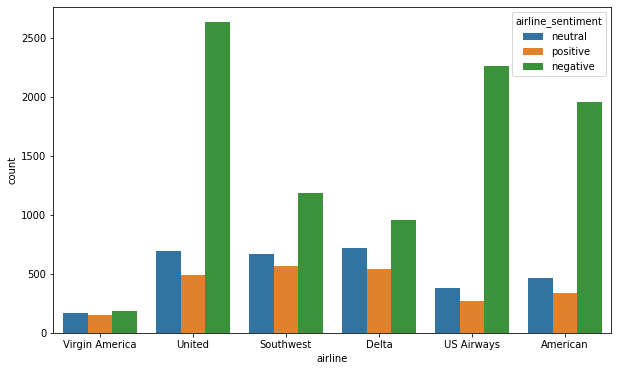

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x=tweets_data['airline'],hue=tweets_data['airline_sentiment']);

Most of the negative tweets are for United airlines followed by US Airways,American,Southwest,Delta,Virgin America.

We are interested in text and airline_sentiment columns for analysis so let's drop other columns.

**Drop the columns**

In [9]:
tweets_copy = tweets_data.copy()
columns = ['tweet_id','airline_sentiment_confidence','negativereason','negativereason_confidence',
           'airline','airline_sentiment_gold','name','negativereason_gold','retweet_count',
           'tweet_coord','tweet_created','tweet_location','user_timezone']
tweets_copy.drop(columns=columns,axis=1,inplace=True)

In [10]:
tweets_copy.shape

(14640, 2)

In [11]:
pd.set_option('display.max_colwidth', None)
tweets_copy.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [13]:
tweets_copy['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

There are 3 types of tweets here.Most of them are negative.

1. There are some URL present in dataset.
2. There is no HTML tag in dataset.
3. Numbers are present.
4. Punctuations are present.
5. Special characters(emoticons,emojis) are present.

In [14]:
X_features = tweets_copy['text']
y = tweets_copy['airline_sentiment']

**HTML Tag removal**

In [15]:
def remove_html_tags(text):
  text_new = BeautifulSoup(text,'html.parser')
  final_text = text_new.get_text()
  return final_text


**http link removal**

In [16]:
def remove_links(text):
  new_text = re.sub(r'http\S+', ' ',text)
  return new_text

**Remove mentions**

In [17]:
def remove_mentions(text):
  new_text = re.sub(r'(@[A-Za-z0-9]+)','', text)
  return new_text

**Replace contractions**

In [18]:
def replace_contractions(text):
    return contractions.fix(text)

**Tokenization**

In [19]:
def text_tokenize(text):
  tokens = word_tokenize(text)
  tokens = [token.strip() for token in tokens]
  return tokens

**Remove numbers and punctuations**

In [20]:
def remove_numbers(text): #this will remove numbers (1,2,3 etc. and also 1st,2nd,3rd,24th )
  pattern = "\\d+[a-zA-Z][a-zA-Z]''|\d+"; 
  new_text = re.sub(pattern,'',text) #re.sub(r'[^a-zA-Z]',' ',text)
  return new_text

In [21]:
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

**Remove special characters**

In [22]:
def remove_special_characters(text):
   new_word = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')       
   return new_word


**Convert to lower case**

In [23]:
def convert_to_lower(text):
   lower_text = text.lower()        
   return lower_text

**Lemmatization**

In [24]:
#def get_wordnet_pos(word):
#    tag = nltk.pos_tag([word])[0][1][0].upper()
#    tag_dict = {"J": wordnet.ADJ,
#                "N": wordnet.NOUN,
#                "V": wordnet.VERB,
#                "R": wordnet.ADV}

#    return tag_dict.get(tag, wordnet.NOUN)

In [25]:
#def apply_lemmatization(words):
#    lemmatizer = WordNetLemmatizer()
#    lemmas = []                           
#    for word in words:
#      if len(word) != 0:
#        lemma = lemmatizer.lemmatize(word, get_wordnet_pos(word))
#        lemmas.append(lemma)  
#    final_text = ' '.join(lemmas)                 
#    return final_text

In [24]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [25]:
def lemmatize_text(words):
    words = nlp(words)
    final_text = words                           
    for word in words:
      final_text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in words])
    return final_text

In [26]:
stopword_list = stopwords.words('english')
stopword_list.remove('not')
stopword_list.remove('no')
stopword_list.remove('too')
stopword_list.append('us')
stopword_list.append('w/')
stopword_list.append('r')
stopword_list.append('u')
stopword_list.append('abt')
stopword_list.append('b/c')
stopword_list.append('yr')

In [29]:
#stopword_list

In [27]:
def remove_stopwords(words):
    new_words = []                       
    for word in words:
        if word not in stopword_list:
            new_words.append(word)        
    return new_words


In [28]:
def replace_abbr(text):  # remove abbreviations
  new_text = re.sub(r'ppl','people',text)
  new_text = re.sub(r'plz','please',new_text)
  new_text = re.sub(r'pls','please',new_text)
  new_text = re.sub(r'luv','love',new_text)
  new_text = re.sub(r'yep','yes',new_text)
  new_text = re.sub(r'thanks','thank',new_text)
  new_text = re.sub(r'thankyou','thank',new_text)
  new_text = re.sub(r'hrs','hour',new_text)
  new_text = re.sub(r'tkt','ticket',new_text)
  new_text = re.sub(r'w/you','with you',new_text)
  new_text = re.sub(r'w/out','without',new_text)
  return new_text

In [29]:
def replace_EmojisTo_text(text):
  new_text = emoji.demojize(text)
  new_text = new_text.replace('_','')
  #new_text = text
  #em_split_emoji = emoji.get_emoji_regexp().split(text)
  #em_split_whitespace = [substr.split() for substr in em_split_emoji]
  #em_split = functools.reduce(operator.concat, em_split_whitespace)
  #for word in em_split:
  #  if word in emojisDict_happySad.keys():
  #    new_text = re.sub(word,emojisDict_happySad[word],new_text)
  return new_text

In [30]:
# emoticons
def load_dict_smileys():   
    return {
        ":‑)":"positive",
        ":-]":"positive",
        ":-3":"positive",
        ":->":"positive",
        "8-)":"positive",
        ":-}":"positive",
        ":)":"positive",
        ":]":"positive",
        ":3":"positive",
        ":>":"positive",
        "8)":"positive",
        ":}":"positive",
        ":o)":"positive",
        ":c)":"positive",
        ":^)":"positive",
        "=]":"positive",
        "=)":"positive",
        ":-))":"positive",
        ":‑D":"positive",
        "8‑D":"positive",
        "x‑D":"positive",
        "X‑D":"positive",
        ":D":"positive",
        "8D":"positive",
        "xD":"positive",
        "XD":"positive",
        ";p":"positive",
        ":‑(":"negative",
        ":‑c":"negative",
        ":‑<":"negative",
        ":‑[":"negative",
        ":(":"negative",
        ":c":"negative",
        ":<":"negative",
        ":[":"negative",
        ":-||":"negative",
        ">:[":"negative",
        ":{":"negative",
        ":@":"negative",
        ">:(":"negative",
        ":'‑(":"negative",
        ":'(":"negative",
        ":‑P":"neutral",
        "X‑P":"neutral",
        "x‑p":"neutral",
        ":‑p":"neutral",
        ":‑Þ":"neutral",
        ":‑þ":"neutral",
        ":‑b":"neutral",
        ":P":"neutral",
        "XP":"neutral",
        "xp":"neutral",
        ":p":"neutral",
        ":Þ":"neutral",
        ":þ":"neutral",
        ":b":"neutral",
        "<3":"positive"
        }

In [31]:
  def replace_EmoticonsTo_Text(text):
    SMILEY_dict = load_dict_smileys()  
    words = text.split()
    reformed = [SMILEY_dict[word] if word in SMILEY_dict else word for word in words]
    text = " ".join(reformed)
    return text

In [32]:
def extract_emojis(tweets):
  emoji_dict = {}
  for tweet in tweets:
    dict1 = {}
    dict1 =demoji.findall(tweet)
    for key,value in zip(dict1.keys(),dict1.values()):
      emoji_dict[key] = value
  return emoji_dict

In [33]:
emojis_dict = extract_emojis(tweets_copy['text'])
emojis_dict

{'↔️': 'left-right arrow',
 '⌚': 'watch',
 '☀️': 'sun',
 '☕': 'hot beverage',
 '☺': 'smiling face',
 '☺️': 'smiling face',
 '♥': 'heart suit',
 '♥️': 'heart suit',
 '⛄': 'snowman without snow',
 '✅': 'check mark button',
 '✈': 'airplane',
 '✈️': 'airplane',
 '✌️': 'victory hand',
 '✔️': 'check mark',
 '✨': 'sparkles',
 '❄️': 'snowflake',
 '❌': 'cross mark',
 '❗': 'red exclamation mark',
 '❤': 'red heart',
 '❤️': 'red heart',
 '➡️': 'right arrow',
 '⤴': 'right arrow curving up',
 '⤵': 'right arrow curving down',
 '⭐': 'star',
 '🆖': 'NG button',
 '🆘': 'SOS button',
 '🇬🇧': 'flag: United Kingdom',
 '🇺🇸': 'flag: United States',
 '🌏': 'globe showing Asia-Australia',
 '🌞': 'sun with face',
 '🌟': 'glowing star',
 '🌴': 'palm tree',
 '🍅': 'tomato',
 '🍷': 'wine glass',
 '🍸': 'cocktail glass',
 '🍻': 'clinking beer mugs',
 '🎀': 'ribbon',
 '🎉': 'party popper',
 '🎲': 'game die',
 '🎵': 'musical note',
 '🐩': 'poodle',
 '🐳': 'spouting whale',
 '🐴': 'horse face',
 '👀': 'eyes',
 '👉': 'backhand index point

In [34]:
print(len(emojis_dict)) # there are 123 unique emojis used in this dataset

123


In [38]:
#emojisDict_happySad = emojis_dict.copy()
#list2 = ['positive ', 'positive ', 'love ', 'negative ', 'negative ', 'love ', 'airplane', 'airplane', 
 #                             'seat', 'positive ', 'positive ', 'positive ', 'positive ', 'positive ',                           
 #                             'sun with face', 'positive ', 'negative ', 'negative ', 'positive ',
#                              'hear-no-evil monkey', 'positive ', 'snowflake', 'positive ', 'positive ',
#                              'positive ', 'cocktail glass', 'negative ', 'negative ', 'positive ',
#                              'grinning face with smiling eyes', 'face blowing a kiss', 'princess', 'flag: United States', 
#                              'globe showing Asia-Australia', 'flag: United Kingdom', 'ribbon', 'sad but relieved face', 'winking face', 
#                              'negative ', 'sparkles', 'party popper', 'positive ', 'zzz', 'negative ', 'positive ', 
#                              'waving hand', 'positive ', 'folded hands', 'angry face with horns', 'pensive face', 'person gesturing NO', 
#                              'NG button', 'negative ', 'positive ', 'palm tree', 'positive ', 'negative ', 'high-heeled shoe', 
#                              'winking face with tongue', 'smiling cat with heart-eyes', 'confused face', 'smiling face with horns', 
#                              'face with steam from nose', 'flexed biceps', 'tired face', 'broken heart', 'sleepy face', 'persevering face', 
#                              'grimacing face', 'person tipping hand', 'face savoring food', 'smirking face', 'confounded face', 'glowing star', 
#                              'mobile phone', 'clinking beer mugs', 'sparkling heart', 'grinning face with sweat', 'heart with ribbon', 
#                              'prohibited', 'left-right arrow', 'face with medical mask', 'star', 'love ', 'red exclamation mark',
#                              'musical note', 'horse face', 'positive ', 'love ', 'grinning squinting face', 'expressionless face', 
#                              'poodle', 'right arrow curving up', 'sun', 'oncoming fist', 'hundred points', 'negative', 'hot beverage',
#                              'mobile phone with arrow', 'goblin', 'see-no-evil monkey', 'love ', 'love ', 'door',
#                              'backhand index pointing right', 'flushed face', 'knocked-out face', 'person walking', 'blue circle',
#                              'neutral ', 'eyes', 'tomato', 'SOS button', 'snowman without snow', 'negative ', 
#                              'game die', 'watch', 'spouting whale', 'right arrow curving down', 'face with open mouth', 'astonished face',
#                              'frowning face with open mouth', 'right arrow']
#i = 0
#for key,value in emojisDict_happySad.items():
#  emojisDict_happySad[key] = list2[i]
#  i = i +1

#print(emojisDict_happySad)


In [35]:
def preprocess_text(text):
  
  new_text = remove_links(text)
  new_text = replace_contractions(new_text)
  new_text = convert_to_lower(new_text)
  new_text = remove_html_tags(new_text) 
  new_text = remove_mentions(new_text)
  new_text = replace_abbr(new_text)
  # Instead of removing emojis,emoticons,we are converting them to text
  new_text = replace_EmojisTo_text(new_text)
  new_text = replace_EmoticonsTo_Text(new_text)
  new_text = remove_special_characters(new_text) # if there is any other special character remaining after above pre-process,remove them
  new_text = remove_numbers(new_text)
  new_text = lemmatize_text(new_text)
  new_text = text_tokenize(new_text)
  new_text = remove_punctuation(new_text)
  new_text = remove_stopwords(new_text) 
  new_text = ' '.join(new_text)

  return new_text


In [36]:
text = preprocess_text(tweets_copy['text'][2148])
print(text)

seat hour inside flight ua iad delay offer water cookie business class fail


In [37]:
tweets_copy['text'][2148]

"@united we've been seating for 5hrs inside flight UA936 at #IAD delayed. We've only been offered water &amp; cookies in business class. #failed"

In [38]:
wordsList = []
for i in range(X_features.shape[0]):
  text = preprocess_text(X_features[i])
  wordsList.append(text)

In [39]:
wordsList[36] #6, [42,36(emoji)]

'moodlighting way fly good experience ever cool calm purpleheart airplane moodlitmonday'

In [40]:
processed_df = pd.DataFrame(wordsList,columns=['text'])
processed_df['airline_sentiment'] = tweets_copy['airline_sentiment']
processed_df.head(10)

,text,airline_sentiment
0,say,neutral
1,plus add commercial experience tacky,positive
2,not today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainment guest face little recourse,negative
4,really big bad thing,negative
5,seriously would pay flight seat not playing really bad thing fly va,negative
6,yes nearly every time fly vx ear worm not go away positive,positive
7,really miss prime opportunity man without hat parody,neutral
8,well not,positive
9,amazing arrive hour early too good,positive


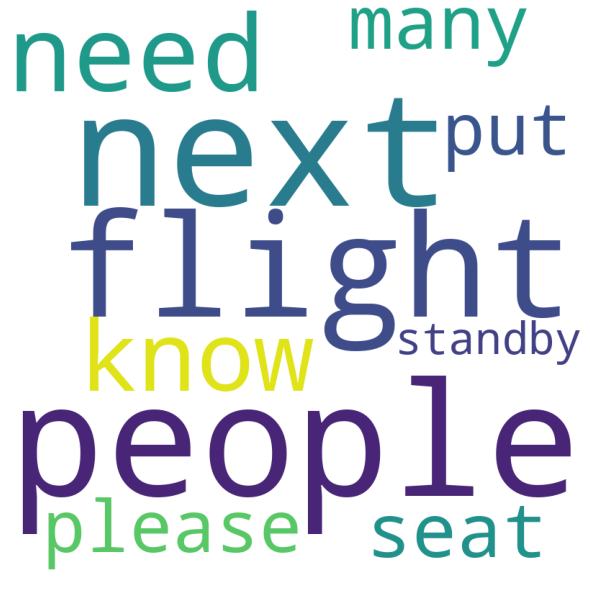

In [41]:
from wordcloud import WordCloud


comment_words = ''
for sentence in wordsList:
  tokens = sentence.split()
  comment_words = " ".join(tokens)

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopword_list,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


**Count Vectorization**

In [79]:
countVector = CountVectorizer(max_features=5000)#min_df=5,ngram_range=(1,2)
X_count_features = countVector.fit_transform(processed_df['text'])

In [80]:
X_count_features.shape

(14640, 5000)

In [81]:
feature_names = countVector.get_feature_names()
corpus_index = [n for n in range(X_count_features.shape[0])]
count_df = pd.DataFrame(X_count_features.T.todense(),index=feature_names, columns=corpus_index)
count_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14600,14601,14602,14603,14604,14605,14606,14607,14608,14609,14610,14611,14612,14613,14614,14615,14616,14617,14618,14619,14620,14621,14622,14623,14624,14625,14626,14627,14628,14629,14630,14631,14632,14633,14634,14635,14636,14637,14638,14639
aa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aadv,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aadvantage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aafail,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ability,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
train_data_features = X_count_features.toarray()
dist = np.sum(train_data_features, axis=0)
df_count = pd.DataFrame(feature_names,columns=['Feature'])
#for tag, count in zip(feature_names, dist):
    #print (count, tag)
df_count['Count'] = dist 
#df_count.sort_values(by=df_count['Count'],ascending=False,axis=1,inplace=True)
df_count.head(30)
#df_count.to_csv('Word_Freq.csv')

,Feature,Count
0,aa,293
1,aadv,2
2,aadvantage,10
3,aafail,2
4,aal,2
5,abandon,3
6,abc,8
7,abi,2
8,ability,7
9,able,121


**TF-IDF Vectorization**

In [133]:
tfidf_vector = TfidfVectorizer(max_features=5000)#,ngram_range=(1,2)
X_tfidf_features = tfidf_vector.fit_transform(processed_df['text'])

In [134]:
X_tfidf_features.shape

(14640, 5000)

In [135]:
feature_names = tfidf_vector.get_feature_names()
corpus_index = [n for n in range(X_tfidf_features.shape[0])]
df_tfidf = pd.DataFrame(X_tfidf_features.T.todense(), index=feature_names, columns=corpus_index)
df_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14600,14601,14602,14603,14604,14605,14606,14607,14608,14609,14610,14611,14612,14613,14614,14615,14616,14617,14618,14619,14620,14621,14622,14623,14624,14625,14626,14627,14628,14629,14630,14631,14632,14633,14634,14635,14636,14637,14638,14639
aa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.33139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aadv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aadvantage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aafail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
le = LabelEncoder()
y = le.fit_transform(processed_df['airline_sentiment'])
y 

array([1, 2, 1, ..., 1, 0, 1])

In [50]:
def fitEvalModel(X_train,y_train,X_test,y_test,model):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  print('Mean Training Score',np.round(np.mean(cross_val_score(model,X_train,y_train,cv=10,n_jobs=-1)),2))
  print('Testing Score:',np.round(accuracy_score(y_test,y_pred),2))
  print('===========Classification Report===================')
  print(classification_report(y_test,y_pred))
  print('==============Confusion Matrix====================')
  conf_mat = confusion_matrix(y_test,y_pred)
  conf_df = pd.DataFrame(conf_mat,index=[i for i in le.classes_],
                     columns = [i for i in le.classes_])
  sns.heatmap(conf_df,annot=True,fmt='d',cmap='YlGnBu');
  plt.ylabel('True label');
  plt.xlabel('Predicted label');


**Model using countVectorizer**

In [83]:
X1 = X_count_features

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=7)

In [85]:
rf_count = RandomForestClassifier(n_estimators=200,random_state=7)

Mean Training Score 0.78
Testing Score: 0.78
===========Classification Report===================
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2784
           1       0.65      0.50      0.56       930
           2       0.70      0.62      0.66       678

    accuracy                           0.78      4392
   macro avg       0.73      0.68      0.70      4392
weighted avg       0.77      0.78      0.77      4392

==============Confusion Matrix====================


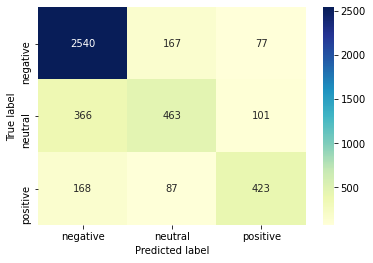

In [86]:
fitEvalModel(X_train,y_train,X_test,y_test,rf_count)

*Naive Bayes*

In [87]:
nb_count = MultinomialNB()

Mean Training Score 0.77
Testing Score: 0.77
===========Classification Report===================
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2784
           1       0.63      0.44      0.52       930
           2       0.71      0.66      0.68       678

    accuracy                           0.77      4392
   macro avg       0.72      0.67      0.69      4392
weighted avg       0.76      0.77      0.76      4392

==============Confusion Matrix====================


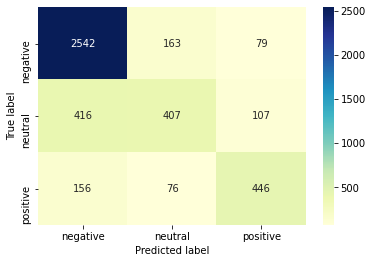

In [88]:
fitEvalModel(X_train,y_train,X_test,y_test,nb_count)

In [89]:
from sklearn.ensemble import GradientBoostingClassifier

In [90]:
xg_count = GradientBoostingClassifier(n_estimators=200,random_state=7)


Mean Training Score 0.75
Testing Score: 0.75
===========Classification Report===================
              precision    recall  f1-score   support

           0       0.77      0.94      0.84      2784
           1       0.69      0.29      0.41       930
           2       0.70      0.60      0.65       678

    accuracy                           0.75      4392
   macro avg       0.72      0.61      0.63      4392
weighted avg       0.74      0.75      0.72      4392

==============Confusion Matrix====================


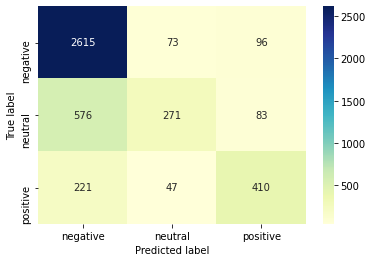

In [91]:
fitEvalModel(X_train,y_train,X_test,y_test,xg_count)

**Model usinf tf-idf**

In [136]:
X2 = X_tfidf_features

In [137]:
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=7)

In [138]:
rf_tfidf = RandomForestClassifier(n_estimators=200,random_state=1)

Mean Training Score 0.78
Testing Score: 0.78
===========Classification Report===================
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      2784
           1       0.65      0.48      0.55       930
           2       0.74      0.59      0.65       678

    accuracy                           0.78      4392
   macro avg       0.73      0.66      0.69      4392
weighted avg       0.77      0.78      0.77      4392

==============Confusion Matrix====================


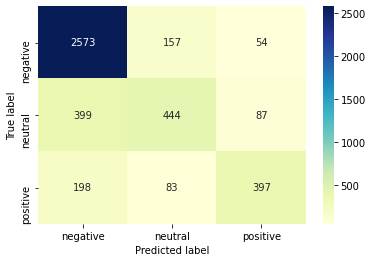

In [139]:
fitEvalModel(X_train,y_train,X_test,y_test,rf_tfidf)

**SUMMARY**

**PRE-PROCESSING**
1. First ,there were some URLs present in dataset.We removed these URLs using *remove_links* function.
2. Then we convert all the text to lower case using *convert_to_lower* so that the words like 'The' and 'the' will not be counted as differnent words.
3. No HTML tags were present in dataset but we still applied *remove_html_tags* function to remove HTML tags.HTML tags might be present in the new test case.
4. Contractions(like didn't etc.) were present.These are removed using *replace_contractions* so that they can be represented like 'did not'. 'not','no' these words are important in case of sentiment analysis.
5. Emoticons,emojis (special characters) were present.This seems useful in case of asentiment analysis.So converting them to text.
6. If some special charaters still remains , we removed them using *remove_special_characters*
7. Then we tokenize the text(converted them into individual words/tokens) using *text_tokenize*.
8. Then we remove the stopwords(frequently used words) from tokenized text using *remove_stopwords*.'not','no' were already removed from stopwords list.These words are important for sentiment analysis.
9. In the last, I applied lemmatization to convert the inflected form of words to root word(which has some dictionary meaning) using *apply_lemmatization*.

**VECTORIZATION**

With pre-processing our universal set of words are ready to use.
But since we can't feed text to machine leaning algorithms,we need to convert them to vectors.
Two techniques are used here to convert text to vectors:-
1. CountVectorizer :- This actually makes a DTM(document term matrix) in which each token(word) is replaced with a number.This number is frequency of that word in a particular document.
2. TfidfVectorizer :- This also gives a DTM in which each token is replaced with a number.Here this number(N) is calculated using a formula:-

  N = Tf*IDF (Term frequency * Inverse Document frequence)

  Tf = frequncy of the word in a doc/total no. of words in that doc
  
  IDF = log(No. of docs/word present in no. of docs)

In both of the vectorization techniques, I have used max_features(=5000).There were 10000+ words in universal set but I wanted to build model using 5000 words. Also I have used ngram_range.Both unigrams and bigrams are being used(unigrams means single token,bigrams means two tokens at a time).

**PERFORMANCE**

I have used random forest for both vectorizations.Both models are giving same accuracy 78%.
I think we can try to increase the accuracy of the model by using other vectorization techniques like word embedding(word2vec,glove).
We can also try to build RNN or LSTM to increase performance.





**Let's try to use word embedding and build a LSTM model**

In [96]:
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [97]:
vocab_size = 5000

In [98]:
wordsList[0]

'say'

In [99]:
totalTokens = sum(len(sentence.split()) for sentence in wordsList)
totalTokens

131455

In [100]:
maxLen = max(len(sentence.split()) for sentence in wordsList)
maxLen

45

In [101]:
oneHot_rep = [one_hot(words,vocab_size) for words in wordsList]
oneHot_rep[0]

[3520]

In [102]:
embedded_docs = pad_sequences(oneHot_rep,maxlen=maxLen,padding='pre')
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       3520], dtype=int32)

In [103]:
from tensorflow.keras.callbacks import EarlyStopping

In [104]:
embedding_vector_features = 60
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=maxLen))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))

In [105]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 45, 60)            300000    
_________________________________________________________________
dropout (Dropout)            (None, 45, 60)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               64400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 364,703
Trainable params: 364,703
Non-trainable params: 0
_________________________________________________________________


In [106]:
X = np.array(embedded_docs)

In [107]:
y1 = pd.get_dummies(y)
y1 = np.array(y1)

In [108]:
X.shape

(14640, 45)

In [109]:
y1.shape

(14640, 3)

In [110]:
X_train,X_test,y_train,y_test = train_test_split(X,y1,test_size=0.3,random_state=1)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=1)

In [111]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(10248, 45)
(2196, 45)
(2196, 45)
(10248, 3)
(2196, 3)
(2196, 3)


In [112]:
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=15,min_delta=0.001,
                                  restore_best_weights=True)
model.fit(X_train,y_train,batch_size=64,epochs=50,validation_data=(X_val,y_val),
          callbacks=[early_stopping_cb])

Epoch 1/50
161/161 [==============================] - 35s 28ms/step - loss: 0.8810 - accuracy: 0.6350 - val_loss: 0.6270 - val_accuracy: 0.7386
Epoch 2/50
161/161 [==============================] - 4s 25ms/step - loss: 0.5479 - accuracy: 0.7823 - val_loss: 0.5682 - val_accuracy: 0.7728
Epoch 3/50
161/161 [==============================] - 4s 26ms/step - loss: 0.4324 - accuracy: 0.8323 - val_loss: 0.5531 - val_accuracy: 0.7782
Epoch 4/50
161/161 [==============================] - 4s 24ms/step - loss: 0.3592 - accuracy: 0.8667 - val_loss: 0.5729 - val_accuracy: 0.7714
Epoch 5/50
161/161 [==============================] - 4s 25ms/step - loss: 0.3242 - accuracy: 0.8802 - val_loss: 0.6180 - val_accuracy: 0.7755
Epoch 6/50
161/161 [==============================] - 4s 26ms/step - loss: 0.2869 - accuracy: 0.8971 - val_loss: 0.6548 - val_accuracy: 0.7714
Epoch 7/50
161/161 [==============================] - 4s 25ms/step - loss: 0.2677 - accuracy: 0.8999 - val_loss: 0.6960 - val_accuracy: 0.760

In [113]:
model.evaluate(X_test, y_test)

69/69 [==============================] - 1s 7ms/step - loss: 0.5488 - accuracy: 0.7873


[0.5487768054008484, 0.7873406410217285]

In [114]:
y_pred = model.predict(X_test) 
y_pred = np.round(y_pred)

In [115]:
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1376
           1       0.63      0.52      0.57       456
           2       0.77      0.64      0.70       364

    accuracy                           0.78      2196
   macro avg       0.74      0.69      0.71      2196
weighted avg       0.77      0.78      0.77      2196



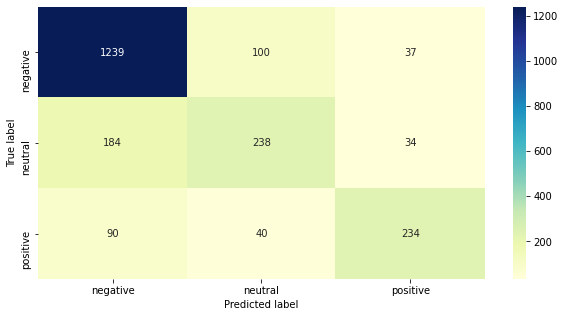

In [116]:
conf = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
conf_df = pd.DataFrame(conf, index = [i for i in le.classes_],
                     columns = [i for i in le.classes_])
conf_df = pd.DataFrame(conf_df)
plt.figure(figsize = (10,5))
sns.heatmap(conf_df, annot=True, fmt='d',cmap='YlGnBu');
plt.ylabel('True label');
plt.xlabel('Predicted label');

In [117]:
yPredFull = model.predict(X)

In [118]:
df = pd.DataFrame(y1)
x = df.stack()
yOrig = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

In [119]:
df1 = pd.DataFrame(yPredFull)
x1 = df1.stack()
yPred = pd.Series(pd.Categorical(x1[x1!=0].index.get_level_values(1)))

In [120]:
mergedDf = pd.DataFrame(X)
mergedDf['Original'] = yOrig
mergedDf['Predicted'] = yPred
df3 = mergedDf[mergedDf['Original'] != mergedDf['Predicted']]
df3.iloc[:,45:].head(10)

,Original,Predicted
0,1,0
1,2,1
2,1,2
4,0,1
5,0,2
6,2,0
9,2,0
12,2,0
13,2,1
16,2,1


In [121]:
df3.shape

(9755, 47)

In [122]:
df_negative = df3[df3['Original'] == 0]
df_negative.iloc[:,45:].head(10)

,Original,Predicted
4,0,1
5,0,2
17,0,2
20,0,2
25,0,1
26,0,2
28,0,1
32,0,2
41,0,2
55,0,1


In [123]:
X_features[41]

"@VirginAmerica Hey, first time flyer next week - excited! But I'm having a hard time getting my flights added to my Elevate account. Help?"

In [124]:
processed_df.head(10)

,text,airline_sentiment
0,say,neutral
1,plus add commercial experience tacky,positive
2,not today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainment guest face little recourse,negative
4,really big bad thing,negative
5,seriously would pay flight seat not playing really bad thing fly va,negative
6,yes nearly every time fly vx ear worm not go away positive,positive
7,really miss prime opportunity man without hat parody,neutral
8,well not,positive
9,amazing arrive hour early too good,positive


In [125]:
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,Bidirectional

In [126]:
embedding_vector_features = 60
biLSTM_model = Sequential()
biLSTM_model.add(Embedding(vocab_size,embedding_vector_features,input_length=maxLen))
biLSTM_model.add(Dropout(0.5))
biLSTM_model.add(Bidirectional(LSTM(128, return_sequences=True)))
biLSTM_model.add(Bidirectional(LSTM(64)))
biLSTM_model.add(Dropout(0.3))
biLSTM_model.add(Dense(3,activation='softmax'))

In [127]:
biLSTM_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
biLSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 60)            300000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 60)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 45, 256)           193536    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 658,275
Trainable params: 658,275
Non-trainable params: 0
________________________________________________

In [128]:
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=15,min_delta=0.001,
                                  restore_best_weights=True)
biLSTM_model.fit(X_train,y_train,batch_size=64,epochs=50,validation_data=(X_val,y_val),
          callbacks=[early_stopping_cb])

Epoch 1/50
161/161 [==============================] - 20s 83ms/step - loss: 0.8489 - accuracy: 0.6342 - val_loss: 0.6361 - val_accuracy: 0.7486
Epoch 2/50
161/161 [==============================] - 11s 71ms/step - loss: 0.5602 - accuracy: 0.7792 - val_loss: 0.5583 - val_accuracy: 0.7760
Epoch 3/50
161/161 [==============================] - 11s 71ms/step - loss: 0.4463 - accuracy: 0.8342 - val_loss: 0.5704 - val_accuracy: 0.7691
Epoch 4/50
161/161 [==============================] - 11s 71ms/step - loss: 0.4030 - accuracy: 0.8558 - val_loss: 0.5694 - val_accuracy: 0.7755
Epoch 5/50
161/161 [==============================] - 11s 71ms/step - loss: 0.3557 - accuracy: 0.8708 - val_loss: 0.6215 - val_accuracy: 0.7668
Epoch 6/50
161/161 [==============================] - 12s 72ms/step - loss: 0.3235 - accuracy: 0.8810 - val_loss: 0.6350 - val_accuracy: 0.7737
Epoch 7/50
161/161 [==============================] - 11s 71ms/step - loss: 0.2981 - accuracy: 0.8896 - val_loss: 0.6880 - val_accuracy:

In [129]:
biLSTM_model.evaluate(X_test, y_test)

69/69 [==============================] - 1s 21ms/step - loss: 0.5495 - accuracy: 0.7883


[0.5495133399963379, 0.7882513403892517]

In [130]:
y_pred = biLSTM_model.predict(X_test) 
y_pred = np.round(y_pred)

In [131]:
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1376
           1       0.67      0.39      0.49       456
           2       0.78      0.60      0.68       364

    accuracy                           0.77      2196
   macro avg       0.75      0.64      0.67      2196
weighted avg       0.76      0.77      0.75      2196



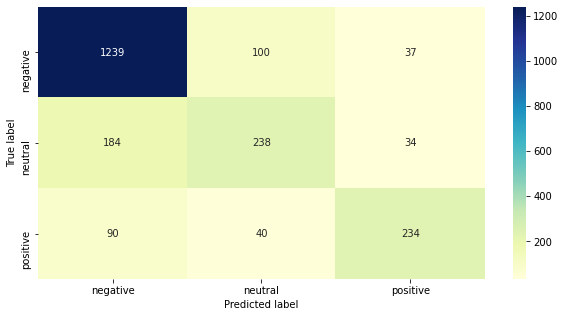

In [132]:
conf1 = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))
conf_df1 = pd.DataFrame(conf1, index = [i for i in le.classes_],
                     columns = [i for i in le.classes_])
plt.figure(figsize = (10,5))
sns.heatmap(conf_df, annot=True, fmt='d',cmap='YlGnBu');
plt.ylabel('True label');
plt.xlabel('Predicted label');

Using LSTM and bidirectional LSTM, accuracy increased a bit. We can further work on text processing to increase the accuracy.